<a href="https://colab.research.google.com/github/MatthewMoor/SOM-2.5PM/blob/master/SOMv8_1ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import somoclu
import math as mt
%matplotlib inline

In [65]:

data_bei = pd.read_csv('BeijingPM2.csv')
data_chen = pd.read_csv('ChengduPM20.csv')
data_guan = pd.read_csv('GuangzhouPM20.csv')
data_shan = pd.read_csv('ShanghaiPM20.csv')
data_shen = pd.read_csv('ShenyangPM20.csv')

datasets = [
    
    data_bei,
    data_chen,
    data_guan,
    data_shan,
    data_shen,
    
]

# describes our datasets
for i, u in enumerate(datasets):
    datasets[i] = u.dropna()
        
for i, data in enumerate(datasets):
    pollution_first = data.iloc[:, 6]
    pollution_second = data.iloc[:, 7]
    pollution_third = data.iloc[:, 8]
    PM = data.iloc[:, 6:9]
    
    if i == 0:
        pollution_fourth = data.iloc[:, 9]
        common_polution = (pollution_first + pollution_second + pollution_third + pollution_fourth) / 4
    else:
        common_polution = (pollution_first + pollution_second + pollution_third) / 3
        
    del datasets[i]['cbwd']
    del datasets[i]['No']
    datasets[i]['average_PM'] = common_polution

for i, data in enumerate(datasets):
    if i == 0:
        datasets[i] = data.drop(data.columns[[5, 6, 7, 8]], axis=1)
    else:
        datasets[i] = data.drop(data.columns[[5, 6, 7]], axis=1)
union = pd.concat(datasets, ignore_index=True)
labels = range(100685)

/home/valyay/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [125]:
Pad = np.array()
for i in range(10):
    a = union.iloc[i,:]
    print(a)
    Pad.append(a)
frame = pd.DataFrame(Pad)
print(frame)

TypeError: Required argument 'object' (pos 1) not found

In [116]:
def data_transformation(data=None, default_data = True): 
  """Transform data in the range 0, 1"""
  if data is None and default_data == True:
    X = pd.read_csv('dust_calculation.csv')
    X = X.iloc[:, 1:]
  else:
    X = data

  from sklearn.preprocessing import MinMaxScaler
  sc = MinMaxScaler(feature_range = (0, 1))
  X = sc.fit_transform(X)
  print(np.shape(X))
  return X

def elbow_plot(X):
  """Draws plot with which we find the cluster"""
  Sum_of_squared_distances = []
  K = range(1,10)
  for k in K:
      km = KMeans(n_clusters=k).fit(X)
      km = km.fit(X)
      Sum_of_squared_distances.append(km.inertia_)

  plt.plot(K, Sum_of_squared_distances, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Sum_of_squared_distances')
  plt.title('Elbow Method For Optimal k')
  plt.show()
  
def draw_umatrix(labels=None):
  if labels != None:
    return som.view_umatrix(bestmatches=True, labels=labels), som.view_component_planes()
  else:
    return som.view_umatrix(bestmatches=True), som.view_component_planes()

def get_coordinates_from_index(n, x, y):
    if n < 0:
        return (-1, -1)
    else:
        return (n % y, n // y)


def get_index_from_coordinates(c, x, y):
    if c[0] < 0 or c[1] < 0 or c[0] > y or c[1] > x:
        return -1
    else:
        return c[1]*y + c[0]


def get_neighbors_from_index(n, x, y):
    c = get_coordinates_from_index(n, x, y)
    neighbors_c = [(c[0]-1, c[1]), (c[0]+1, c[1]),
                   (c[0], c[1]-1), (c[0], c[1]+1)]
    neighbors_c = [c for c in neighbors_c
                   if c[0] >= 0 and c[1] >= 0 and c[1] < x and c[0] < y]
    neighbors = [get_index_from_coordinates(c, x, y) for c in neighbors_c]
    return list(set(neighbors))


def calculate_topographical_error(som, n_rows, n_columns):
    surface_state = som.get_surface_state()
    bmus_1st_and_2nd = np.argsort(surface_state, axis=1)[:, :2]
    all_2nd = []
    for i, second_index in enumerate(bmus_1st_and_2nd[:, 1]):
        all_2nd.append([])
        distance = surface_state[i, second_index]
        for s_i, s in enumerate(surface_state[i]):
            if abs(s-distance) < 10e-5:
                all_2nd[-1].append(s_i)
    neighbors = [get_neighbors_from_index(t, n_rows, n_columns)
                 for t in bmus_1st_and_2nd[:, 0]]

    e_t = 1-np.mean([len(set(second) & set(neighs)) > 0 for (second, neighs) in
                     zip(all_2nd, neighbors)])
    return e_t


def find_clusters(labels):
  """We find line our clusters of datasets"""
  clusters = {}
  for k in labels:  # The data instance you are interested in 
      cluster = str(som.clusters[som.bmus[k, 1], som.bmus[k, 0]])
      if not cluster in clusters.keys():
          clusters[cluster] = []
      clusters[cluster] += [k]
  import json
  print(json.dumps(clusters, sort_keys=True, indent=4))
  return clusters
  
    
 
  
def cluster_data(number_cluster, clusters):
  """Pulling out data-points in rows"""
  try:
    pulled_data = []
    detailed_cluster = clusters[number_cluster]
    for i in detailed_cluster:
      pulled_data.append(X[i])
    quantity_strings = len(pulled_data)
  except KeyError:
    print('Your data out of range!\nSolution: Enter correct cluster value, your length dict - {}'.format(len(clusters.keys())))
  print("Quantity strings in clusters - {} \n Approximate map size - {} ".format(quantity_strings,mt.sqrt(5*mt.sqrt(quantity_strings))))
  return np.asarray(pulled_data)

 
def quant_err(data):
    bmu_dists = []
    bmus = som.get_bmus(som.get_surface_state(data))
    #print(bmus)  
    bmus_feat = som.codebook
    #print(bmus_feat)
    for index, input_vector in enumerate(data):
        bmu = bmus[index]
        #print(bmu)  
        bmu_feat = bmus_feat[bmu[0], bmu[1]]
        #print(bmu_feat)
        bmu_dists.append(np.linalg.norm(input_vector-bmu_feat))
    return np.array(bmu_dists).mean()
      
def quant_err_clusters(data, clusters):
    cluster_bmu_dists = []
    for index_cluster in clusters:
        data_cluster = cluster_data(index_cluster, clusters)
        #print(data_cluster)
        error_certain_cluster = quant_err(data_cluster)
        #print(error_certain_cluster)
        cluster_bmu_dists.append([index_cluster, error_certain_cluster])
    return np.array(cluster_bmu_dists)
    

def data_presentation(number_cluster, clusters):
    pulled_data = pd.DataFrame()
    detailed_cluster = clusters[number_cluster]
    for i in detailed_cluster:
        pulled_data.append(union.iloc[i,:])
    return pulled_data


In [67]:
n_rows, n_columns = 40, 40
X = data_transformation(union)
labels = range(X.shape[0])

som = somoclu.Somoclu(n_columns, n_rows, data=X, maptype="planar", initialization="pca")
som.train(epochs=10,radius0=38, radiusN=1,radiuscooling="exponential",scale0=0.1, scaleN=0.035, scalecooling="exponential")
e_t = calculate_topographical_error(som, n_rows, n_columns)
print("The topographical error obtained is: %s"%e_t)

/home/valyay/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(100684, 13)
The topographical error obtained is: 0.18418020738151042


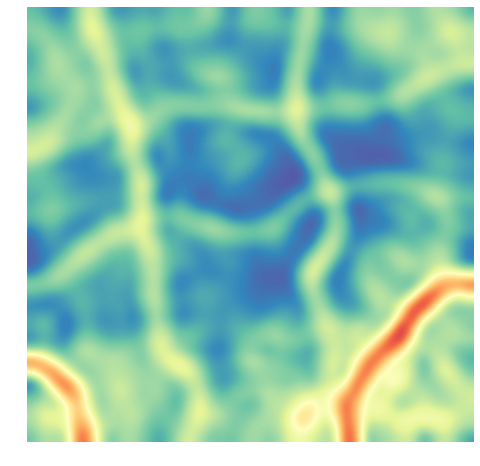

<module 'matplotlib.pyplot' from '/home/valyay/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [60]:
som.view_umatrix()

In [8]:
%time som.train(epochs=10000,radius0=1,radiusN=0.000001,radiuscooling="exponential",scale0=0.035, scaleN=0.001, scalecooling="exponential")
e_t = calculate_topographical_error(som, n_rows, n_columns)
print("The topographical error obtained is: %s"%e_t)

CPU times: user 23h 18min 59s, sys: 45 s, total: 23h 19min 44s
Wall time: 5h 54min 32s
The topographical error obtained is: 0.5041118747765285


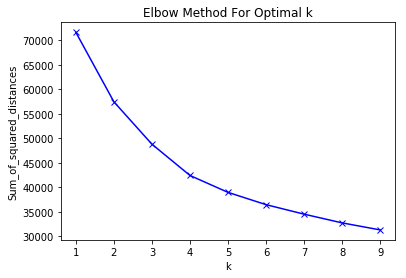

In [13]:
elbow_plot(X)

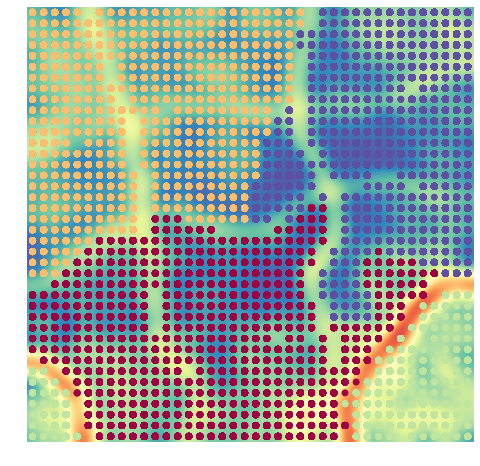

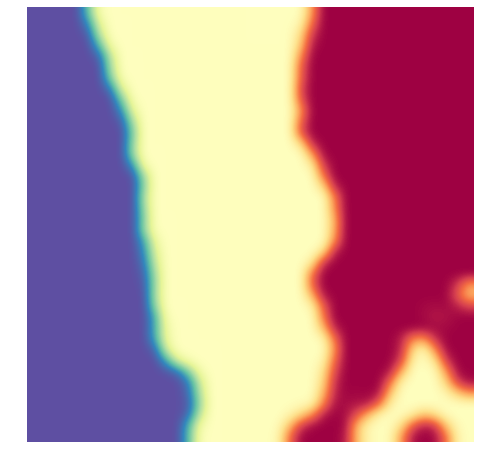

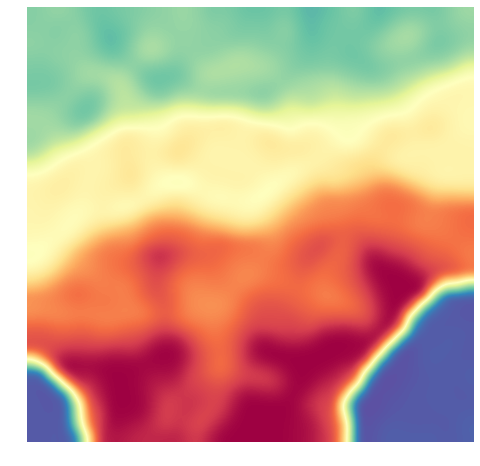

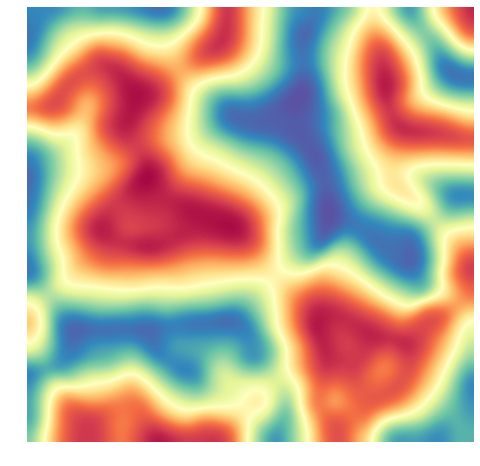

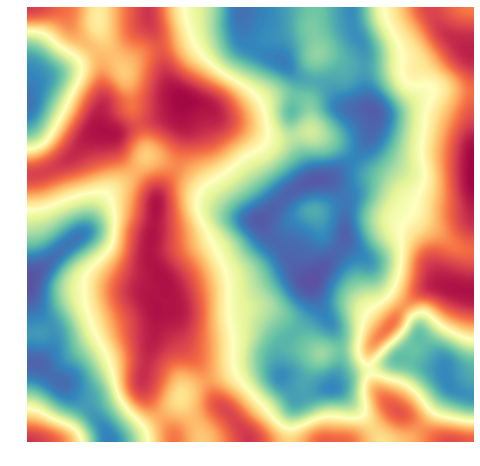

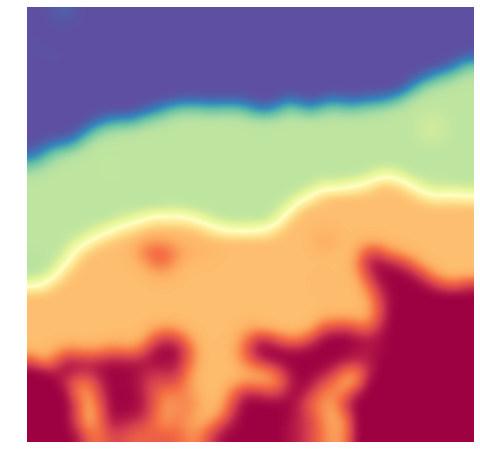

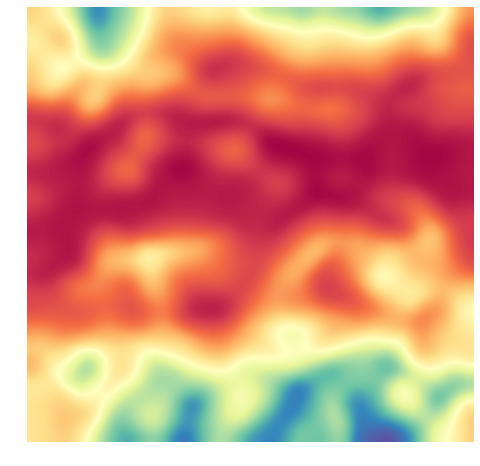

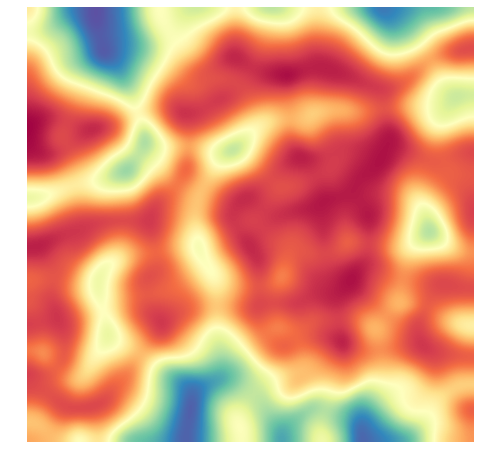

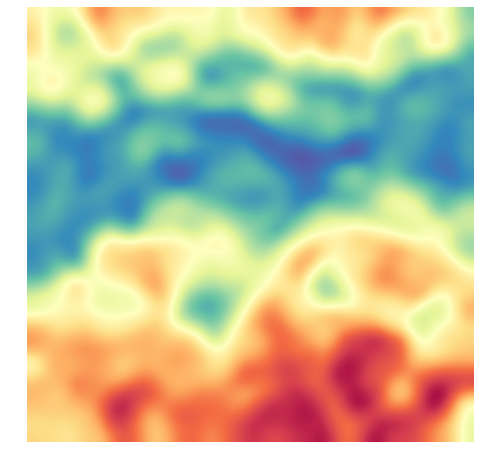

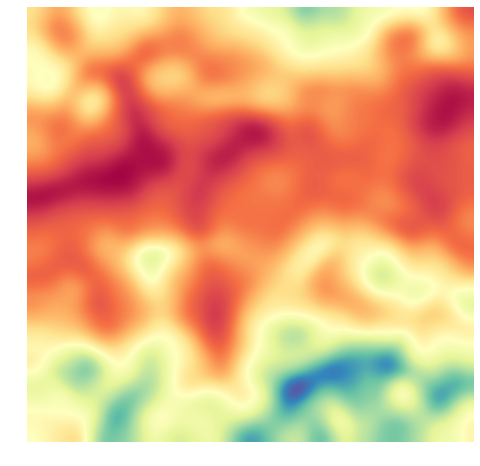

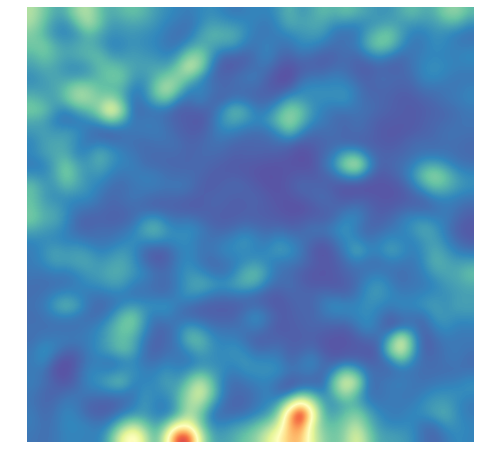

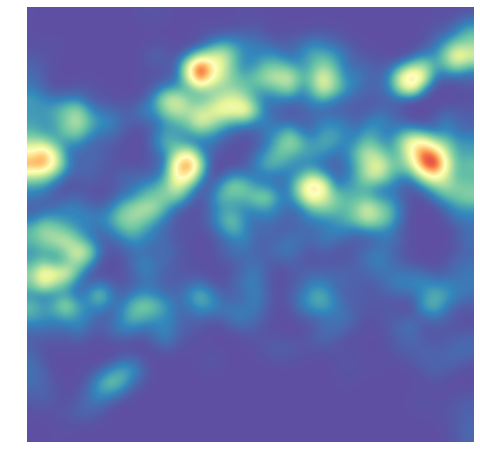

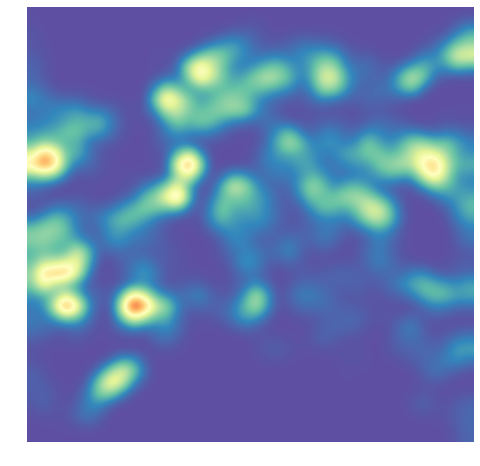

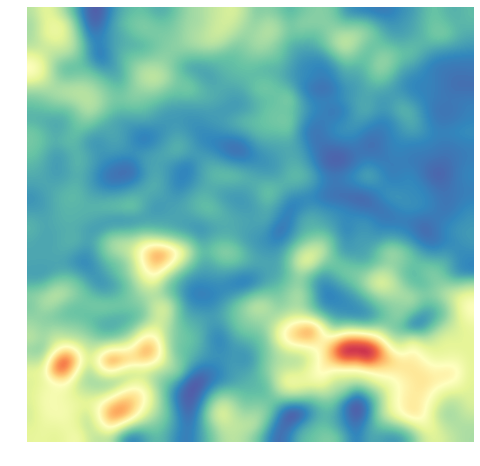

(<module 'matplotlib.pyplot' from '/home/valyay/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/home/valyay/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>)

In [68]:
algorithm = KMeans(n_clusters = 4)
som.cluster(algorithm=algorithm)
draw_umatrix()

In [69]:
# We find own data-points for each clusters
clusters = find_clusters(labels)

{
    "0": [
        7670,
        7671,
        8348,
        9590,
        9591,
        9592,
        9593,
        9594,
        9595,
        9596,
        9597,
        9598,
        9614,
        9615,
        9616,
        9617,
        9618,
        9619,
        9620,
        9621,
        9622,
        9623,
        9624,
        9638,
        9639,
        9640,
        9641,
        9642,
        9643,
        9644,
        9645,
        9646,
        9662,
        9663,
        9664,
        9665,
        9666,
        9667,
        9668,
        9669,
        9670,
        9685,
        9686,
        9687,
        9688,
        9689,
        9690,
        9705,
        9706,
        9707,
        9708,
        9709,
        9710,
        9711,
        9712,
        9713,
        9714,
        9718,
        9728,
        9729,
        9730,
        9731,
        9732,
        9733,
        9734,
        9735,
        9736,
        9751,
        9752,
        9753,
       

In [88]:
quantization = quant_err_clusters(X, clusters)
print(quantization)

Quantity strings in clusters - 26682 
 Approximate map size - 28.57851098220773 
Quantity strings in clusters - 29783 
 Approximate map size - 29.37494840965768 
Quantity strings in clusters - 27678 
 Approximate map size - 28.841555440730502 
Quantity strings in clusters - 16541 
 Approximate map size - 25.358609884270784 
[['3' '1.2298761950691535']
 ['2' '1.0078994620092236']
 ['0' '0.807917829301652']
 ['1' '1.2683968405721038']]


In [90]:
specific_cluster = cluster_data('3', clusters)

Quantity strings in clusters - 26682 
 Approximate map size - 28.57851098220773 


In [72]:
n_rows, n_columns = 29, 29
som = somoclu.Somoclu(n_columns, n_rows, data=specific_cluster, maptype="toroid", initialization="pca")
%time som.train(epochs=10,radius0=28, radiusN=1,radiuscooling="exponential",scale0=0.1, scaleN=0.035, scalecooling="exponential")

CPU times: user 17.1 s, sys: 150 ms, total: 17.3 s
Wall time: 5.37 s


In [18]:
%time som.train(epochs=10000,radius0=1,radiusN=0.000001,radiuscooling="exponential",scale0=0.035, scaleN=0.001, scalecooling="exponential")
e_t = calculate_topographical_error(som, n_rows, n_columns)
print("The topographical error obtained is: %s"%e_t)

CPU times: user 2h 22min 41s, sys: 10.5 s, total: 2h 22min 52s
Wall time: 38min 37s
The topographical error obtained is: 0.5026902847469923


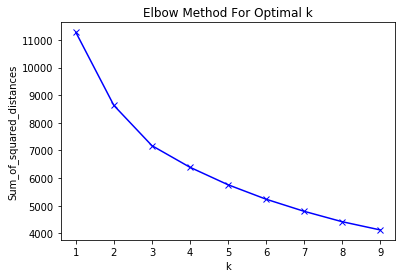

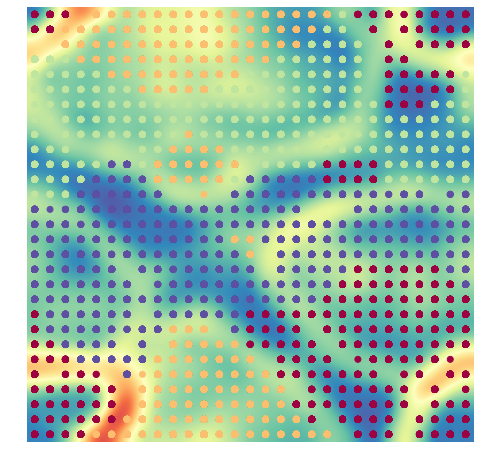

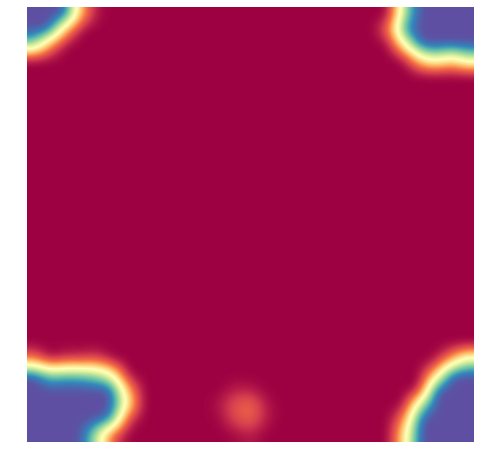

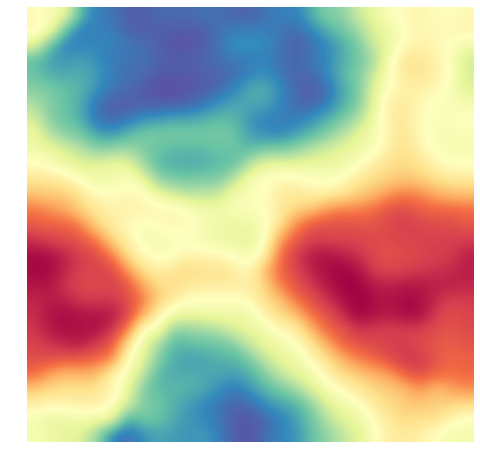

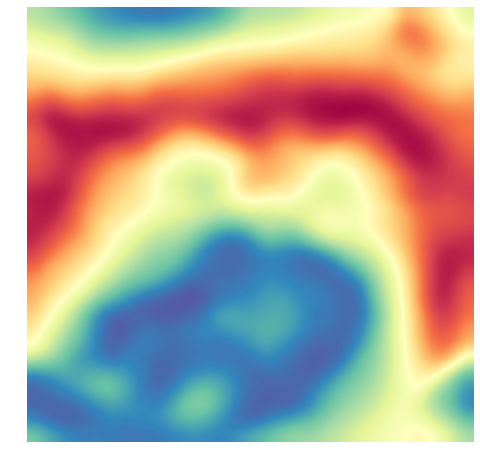

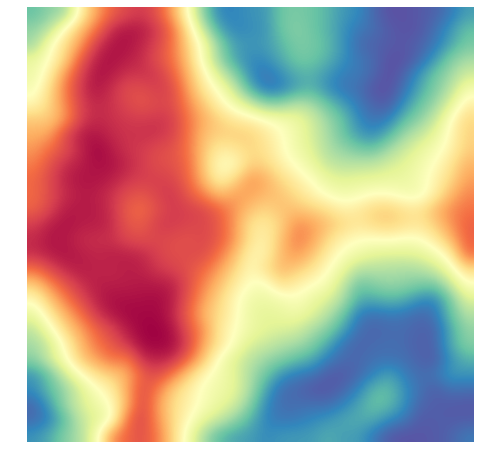

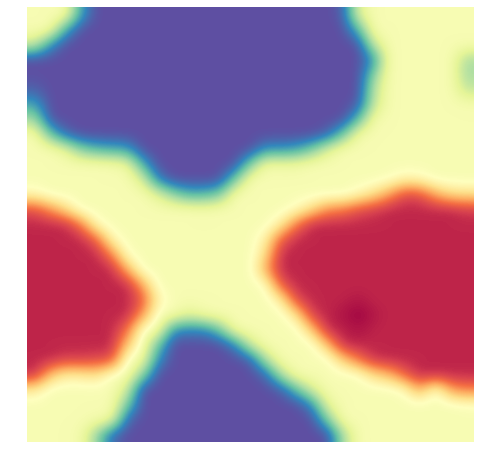

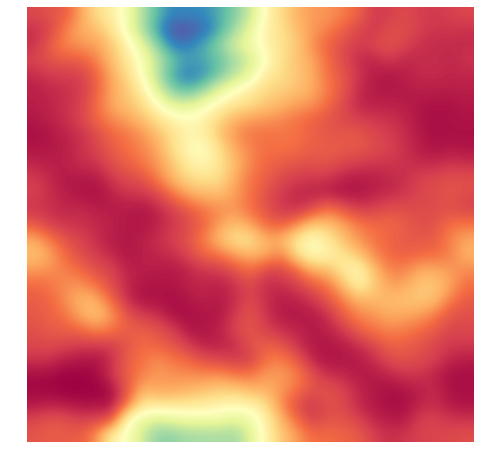

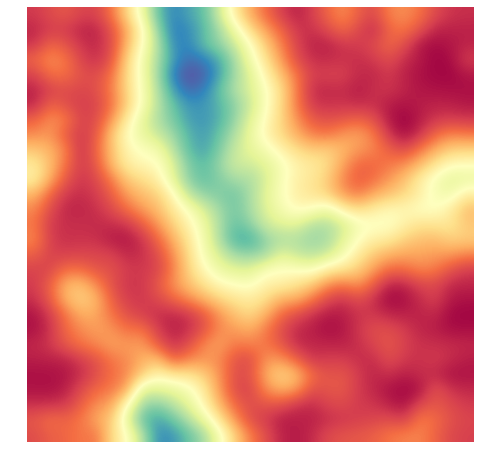

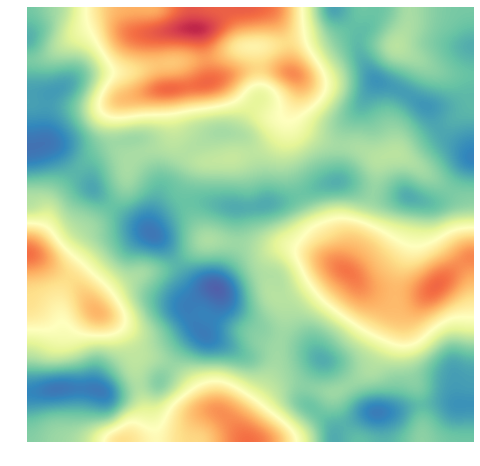

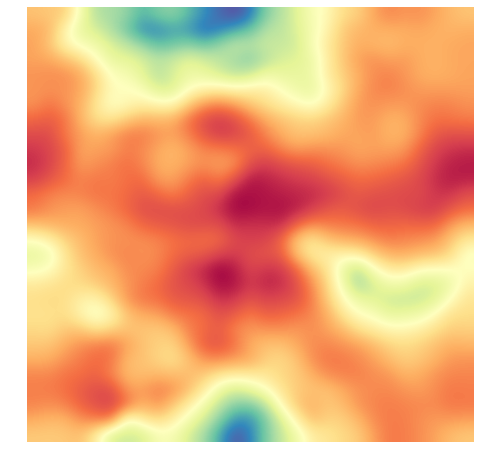

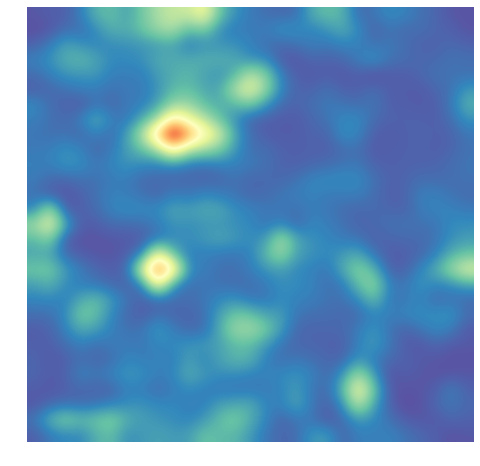

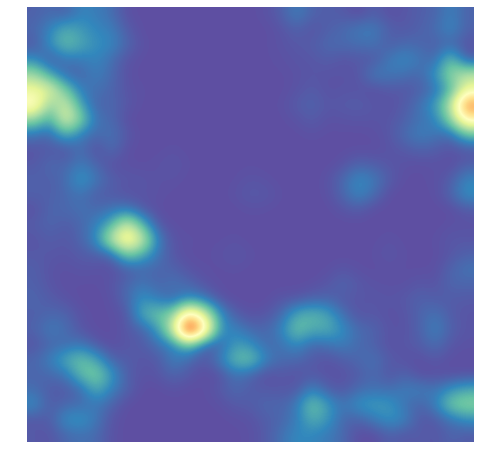

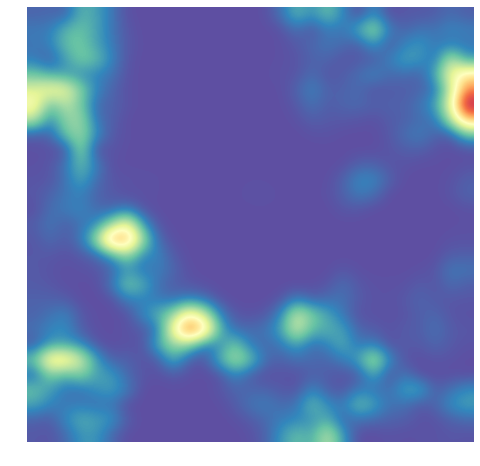

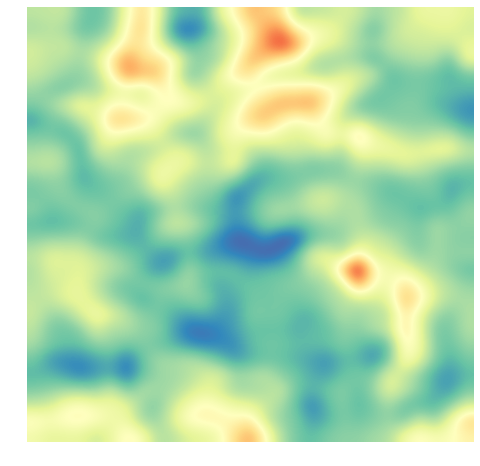

(<module 'matplotlib.pyplot' from '/home/valyay/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/home/valyay/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>)

In [73]:
elbow_plot(specific_cluster)

algorithm = KMeans(n_clusters = 4)
som.cluster(algorithm=algorithm)
draw_umatrix()

In [91]:
quantization = quant_err(specific_cluster)
print(quantization)
for index_cluster in clusters:
    specific_cluster = cluster_data(index_cluster, clusters)
    quantization = quant_err(specific_cluster)
    print(quantization)

1.2298761950691535
Quantity strings in clusters - 26682 
 Approximate map size - 28.57851098220773 
1.2298761950691535
Quantity strings in clusters - 29783 
 Approximate map size - 29.37494840965768 
1.0078994620092236
Quantity strings in clusters - 27678 
 Approximate map size - 28.841555440730502 
0.807917829301652
Quantity strings in clusters - 16541 
 Approximate map size - 25.358609884270784 
1.2683968405721038


In [117]:
data_cluster = data_presentation('3', clusters)

In [118]:
print(data_cluster)

Empty DataFrame
Columns: []
Index: []


In [1]:
labels = range(specific_cluster.shape[0])
clusters = find_clusters(labels)

def quant_err(data, clusters = None):
    """ 
       Computes the quantization error of the SOM.
       It uses the data fed at last training.
    """
    if clusters == None: 
      bmu_dists = []
      bmus = som.get_bmus(som.get_surface_state(data))
      bmus_feat = som.codebook
      for index, input_vector in enumerate(data):
          bmu = bmus[index]
          bmu_feat = bmus_feat[bmu[0], bmu[1]]
          bmu_dists.append(np.linalg.norm(input_vector-bmu_feat))
      return np.array(bmu_dists).mean()
    else:
      cluster_bmu_dists = []
      for index_cluster in clusters:
        data_cluster = cluster_data(index_cluster, clusters)
        print(data_cluster)
        error_certain_cluster = quant_err(data_cluster)
        cluster_bmu_dists.append([index_cluster, error_certain_cluster])
      return np.array(cluster_bmu_dists)

quantization = quant_err(specific_cluster)
print(quantization)

NameError: name 'specific_cluster' is not defined

In [38]:
import jdc
import numpy as np
import itertools 


class SOM(object):
    
    
    def __init__(self,h,w,dim_feat):
        """
            Construction of a zero-filled SOM.
            h,w,dim_feat: constructs a (h,w,dim_feat) SOM.
        """
        self.shape = (h,w,dim_feat)
        self.som = np.zeros((h,w,dim_feat))

        # Training parameters
        self.L0 = 0.0
        self.lam = 0.0
        self.sigma0 = 0.0
    
    
    def train(self,data,L0,lam,sigma0,initializer=np.random.rand):
        """ 
            Training procedure for a SOM.
            data: a N*d matrix, N the number of examples, 
                  d the same as dim_feat=self.shape[2].
            L0,lam,sigma0: training parameters.
            initializer: a function taking h,w and dim_feat (*self.shape) as 
                         parameters and returning an initial (h,w,dim_feat) tensor.
        """
        self.L0 = L0
        self.lam = lam
        self.sigma0 = sigma0
        self.data = data
        self.som = initializer(*self.shape)
        bmu_list = []
        
        for t in itertools.count():
            if self.sigma(t) < 0.5:
                break
            i_data =  np.random.choice(range(len(data)))

            bmu = self.find_bmu(data[i_data])
            self.update_som(bmu,data[i_data],t)
            # check out
            bmu_list.append(bmu)
        return bmu_list
            
    
    def find_bmu(self, input_vec):
        """
            Find the BMU of a given input vector.
            input_vec: a d=dim_feat=self.shape[2] input vector.
        """
        list_bmu = []
        for y in range(self.shape[0]):
            for x in range(self.shape[1]):
                dist = np.linalg.norm((input_vec-self.som[y,x]))
                list_bmu.append(((y,x),dist))
        list_bmu.sort(key=lambda x: x[1])
        return list_bmu[0][0]
    
    
    def update_bmu(self,bmu,input_vector,t):
        """
            Update rule for the BMU.
            bmu: (y,x) BMU's coordinates.
            input_vector: current data vector.
            t: current time.
        """
        self.som[bmu] += self.L(t)*(input_vector-self.som[bmu])

        
    def L(self, t):
        """
            Learning rate formula.
            t: current time.
        """
        return self.L0*np.exp(-t/self.lam) 

    
    
    def update_som(self,bmu,input_vector,t):
        """ 
            Calls the update rule on each cell.
            bmu: (y,x) BMU's coordinates.
            input_vector: current data vector.
            t: current time.
        """
        for y in range(self.shape[0]):
            for x in range(self.shape[1]):
                dist_to_bmu = np.linalg.norm((np.array(bmu)-np.array((y,x))))
                self.update_cell((y,x),dist_to_bmu,input_vector,t)

                
    def update_cell(self,cell,dist_to_bmu,input_vector,t):
        """ 
            Computes the update rule on a cell.
            cell: (y,x) cell's coordinates.
            dist_to_bmu: L2 distance from cell to bmu.
            input_vector: current data vector.
            t: current time.
        """
        self.som[cell] += self.N(dist_to_bmu,t)*self.L(t)*(input_vector-self.som[cell])
        # My attempts
#         self.new_som.append(self.som[cell])

        
    def N(self,dist_to_bmu,t):
        """ 
            Computes the neighbouring penalty.
            dist_to_bmu: L2 distance to bmu.
            t: current time.
        """
        curr_sigma = self.sigma(t)
        return np.exp(-(dist_to_bmu**2)/(2*curr_sigma**2))

    
    def sigma(self, t):
        """
            Neighbouring radius formula.
            t: current time.
        """
        return self.sigma0*np.exp(-t/self.lam)
    
    
    def quantization_error(self):
        """ 
            Computes the quantization error of the SOM.
            It uses the data fed at last training.
        """
        bmu_dists = []
        for input_vector in self.data:
            bmu = self.find_bmu(input_vector)
            bmu_feat = self.som[bmu]
            bmu_dists.append(np.linalg.norm(input_vector-bmu_feat))
        return np.array(bmu_dists).mean()

In [46]:
som_square = SOM(40,40, 13)
train_som = som_square.train(X,L0=0.8,lam=1e2,sigma0=10)
bmu = train_som
mapp = som_square.som

In [44]:
print(mapp.quantization_error())

AttributeError: 'numpy.ndarray' object has no attribute 'quantization_error'

In [47]:
print(som_square.quantization_error())

0.4055960377532623


In [48]:
som_square = SOM(29,29, 13)
train_som = som_square.train(specific_cluster,L0=0.8,lam=1e2,sigma0=10)
bmu = train_som
mapp = som_square.som

In [49]:
print(som_square.quantization_error())

0.29963716197197615


In [50]:
som_square = SOM(40,40, 13)
train_som = som_square.train(specific_cluster,L0=0.8,lam=1e2,sigma0=10)
bmu = train_som
mapp = som_square.som
print(som_square.quantization_error())

0.2820734871115981
